## Model Tuning
기초적인 feature, 알고리즘 등을 설정한 후 모델 튜닝 사이클에 진입  
(파라미터 설정/변경 - 모델 학습 - 모델 검증) 반복  
* Linear Regression  
binary한 parameter가 두 종류(intercept, normalize), 총 네 가지 경우만 존재함 - 매뉴얼한 튜닝 가능
* Light GBM  
매우 많은 파라미터, 다양한 값을 가질 수 있음  

어떻게 하지?

## Hyperparameter Optimization
다양한 tool을 사용해서 최적의 parameter set을 찾는다
* Scikit learn 
  * GridSearch CV  
  모든 조합을 사용, 그 중 최적을 찾음. 이때 각 paramter가 가질 수 있는 값은 사용자가 넣어줘야 함
  * RandomizedSearch CV  
  N개의 조합을 임의로 선택, 이때 범위 및 분포 지정이 가능함  

보다 고도화된 접근은 없나? Bayesian Optimization 등을 적용!

* Hyperopt
  * TPE algorithm
  * 사용이 다소 까다로우나 대략적인 감(어떤 param을 튜닝해야겠다)이 있다면 더 빠름, 숙련자에게 좋음
* Optuna
  * 다양한 알고리즘(TPE, Gaussian Process) 지원, 조합해서 사용
  * 두 가지 문법; hyperopt와 유사한 문법 또는 사전에 약속된 search space를 활용한 간단한 문법
  * 두 번째 문법(integration 모듈)은 입문자에게 용이함

N-fold CV를 HPO에 사용할 수는 있다  
하지만, HPO 자체가 매우 오래 걸리는 작업이므로 실전에서는 잘 사용하지 않음 
### QnA  
* 실제로 성능에 기여하는 부분은?  
EDA를 통한 feature engineering >> algorithm selection > ensemble >= HPO  


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
!pip install optuna

In [32]:
from hyperopt import STATUS_OK, Trials, hp, space_eval, tpe, fmin
from lightgbm import LGBMClassifier
import lightgbm as lgb
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split
import seaborn as sns
import warnings

In [6]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

In [7]:
from google.colab import files
files.upload()

Saving dku_data.zip to dku_data.zip


In [8]:
!unzip dku_data.zip

Archive:  dku_data.zip
   creating: build/
   creating: build/feature/
  inflating: build/feature/feature.csv  
   creating: build/sub/
   creating: data/
  inflating: data/sample_submission.csv  
  inflating: data/test.csv           
  inflating: data/train.csv          


In [17]:
!mkdir ./build/val ./build/tst

In [10]:
data_dir = Path('./data')
feature_dir = Path('./build/feature')
val_dir = Path('./build/val')
tst_dir = Path('./build/tst')
sub_dir = Path('./build/sub')

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = data_dir / 'sample_submission.csv'

target_col = 'class'
n_fold = 5
n_class = 3
seed = 42

### HPO - Hyperopt

In [11]:
algo_name = 'lgb_hyperopt'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'
p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

In [12]:
df = pd.read_csv(feature_file, index_col=0)
print(df.shape)
df.head()

(400000, 20)


,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,airmass_u,class,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,d_dered_ig,d_dered_zg,d_dered_rz,d_dered_iz,d_obs_det
id,,,,,,,,,,,,,,,,,,,,
0,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,2.9444,1.1898,0.0,-0.1397,-0.0790,-0.0544,-0.0403,-0.0307,-2.6257,-3.3488,2.0462,0.7232,-15.0556
1,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,0.6931,1.2533,1.0,-0.0857,-0.0574,-0.0410,-0.0322,-0.0343,-0.7683,-0.8698,0.2767,0.1016,-0.3069
2,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,1.0986,1.0225,0.0,-0.1787,-0.1388,-0.0963,-0.0718,-0.0540,-0.3649,-0.3905,0.1440,0.0257,-0.9014
3,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,1.6094,1.2054,0.0,-0.3070,-0.1941,-0.1339,-0.1003,-0.0795,-1.2000,-1.4395,0.5321,0.2395,-1.3906
4,17.9826,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,2.6391,1.1939,0.0,-0.6820,-0.2653,-0.1794,-0.1339,-0.1067,-2.2436,-2.5579,0.9871,0.3144,-9.3609


In [13]:
y = df[target_col].values[:320000]
df.drop(target_col, axis=1, inplace=True)
trn = df.iloc[:320000].values
tst = df.iloc[320000:].values
feature_name = df.columns.tolist()
print(y.shape, trn.shape, tst.shape)

(320000,) (320000, 19) (80000, 19)


In [14]:
X_trn, X_val, y_trn, y_val = train_test_split(trn, y, test_size=.2, random_state=seed)

In [15]:
params = {
    "objective": "multiclass",
    "n_estimators": 1000,
    "subsample_freq": 1,
    "random_state": seed,
    "n_jobs": -1,
}

space = {
    "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.3)),
    "num_leaves": hp.choice("num_leaves", [15, 31, 63, 127]),
    "colsample_bytree": hp.quniform("colsample_bytree", .5, .9, 0.1),
    "subsample": hp.quniform("subsample", .5, .9, 0.1),
    "min_child_samples": hp.choice('min_child_samples', [10, 25, 100])
}

In [16]:
def objective(hyperparams):
    model = lgb.LGBMClassifier(**params, **hyperparams)
    model.fit(X=X_trn, y=y_trn,
              eval_set=[(X_val, y_val)],
              eval_metric="multi_logloss",
              early_stopping_rounds=10,
              verbose=False)
    score = model.best_score_["valid_0"]["multi_logloss"]

    return {'loss': score, 'status': STATUS_OK, 'model': model}

trials = Trials()
best = fmin(fn=objective, space=space, trials=trials,
            algo=tpe.suggest, max_evals=10, verbose=1)

hyperparams = space_eval(space, best)
n_best = trials.best_trial['result']['model'].best_iteration_
params.update(hyperparams)
print(params)

100%|██████████| 10/10 [09:01<00:00, 54.17s/it, best loss: 0.16187907754975886]
{'objective': 'multiclass', 'n_estimators': 1000, 'subsample_freq': 1, 'random_state': 42, 'n_jobs': -1, 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.0247856285183672, 'min_child_samples': 10, 'num_leaves': 127, 'subsample': 0.5}


In [18]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

In [ ]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = lgb.LGBMClassifier(**params)
    clf.fit(trn[i_trn], y[i_trn],
            eval_set=[(trn[i_val], y[i_val])],
            eval_metric='multiclass',
            early_stopping_rounds=10)
    
    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    p_tst += clf.predict_proba(tst) / n_fold

In [20]:
print(f'{accuracy_score(y, np.argmax(p_val, axis=1)) * 100:.4f}%')
print(p_val.shape, p_tst.shape)

93.2863%
(320000, 3) (80000, 3)


In [21]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

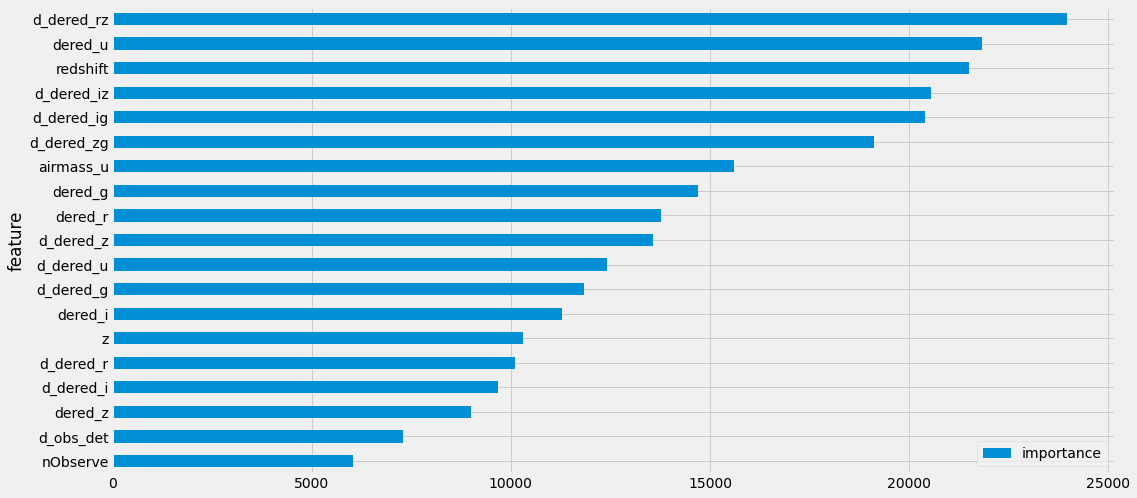

In [22]:
imp = pd.DataFrame({'feature': df.columns, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

### HPO - Optuna

In [44]:
algo_name = 'lgb_optuna'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'
p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

In [45]:
df = pd.read_csv(feature_file, index_col=0)
y = df[target_col].values[:320000]
df.drop(target_col, axis=1, inplace=True)
trn = df.iloc[:320000].values
tst = df.iloc[320000:].values
feature_name = df.columns.tolist()
print(y.shape, trn.shape, tst.shape)

(320000,) (320000, 19) (80000, 19)


In [46]:
X_trn, X_val, y_trn, y_val = train_test_split(trn, y, test_size=.2, random_state=seed)

In [48]:
params = {
    "objective": "multiclass",
    "metric": "multi_logloss",
    "num_class": 3,
    "n_estimators": 1000,
    "subsample_freq": 1,
    "lambda_l1": 0.,
    "lambda_l2": 0.,
    "random_state": seed,
    "n_jobs": -1,
}

In [ ]:
import optuna.integration.lightgbm as lgb

dtrain = lgb.Dataset(X_trn, label=y_trn)
dval = lgb.Dataset(X_val, label=y_val)

model = lgb.train(params, dtrain, valid_sets=[dtrain, dval], verbose_eval=100, early_stopping_rounds=10)

prediction = np.argmax(model.predict(X_val, num_iteration=model.best_iteration), axis=1)
accuracy = accuracy_score(y_val, prediction)

params = model.params
print("Best params:", params)
print("  Accuracy = {}".format(accuracy))
print("  Params: ")
for key, value in params.items():
    print("    {}: {}".format(key, value))

In [50]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

In [ ]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = LGBMClassifier(**trial.params)
    clf.fit(trn[i_trn], y[i_trn],
            eval_set=[(trn[i_val], y[i_val])],
            eval_metric='multiclass',
            early_stopping_rounds=10)
    
    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    p_tst += clf.predict_proba(tst) / n_fold

In [52]:
print(f'{accuracy_score(y, np.argmax(p_val, axis=1)) * 100:.4f}%')
print(p_val.shape, p_tst.shape)

92.8525%
(320000, 3) (80000, 3)


In [53]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

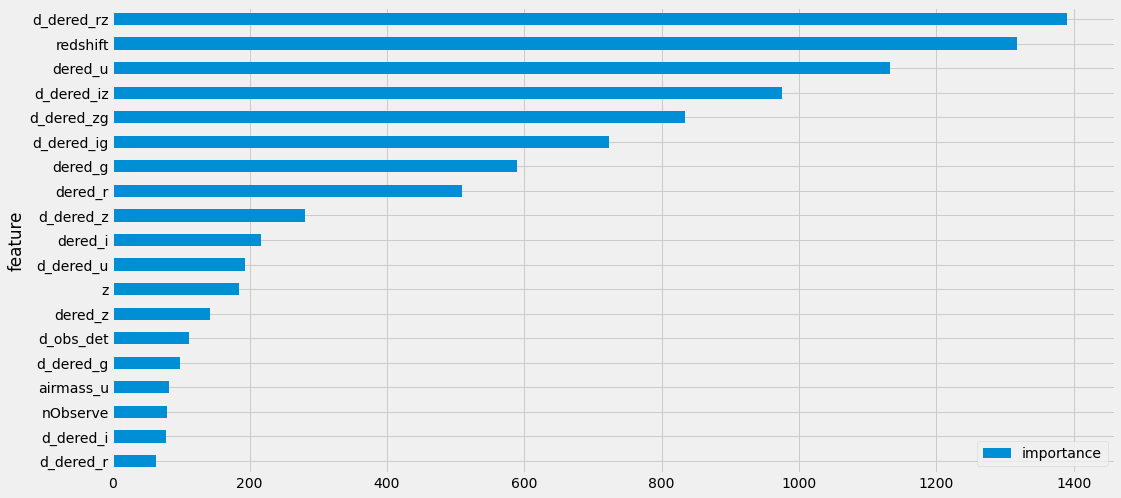

In [54]:
imp = pd.DataFrame({'feature': df.columns, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

## 제출 파일 생성

In [55]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub[target_col] = np.argmax(p_tst, axis=1)
sub.head()
# sub[target_col].value_counts()
sub.to_csv(sub_file)

(80000, 1)


In [56]:
!zip -r sub.zip ./build/sub

  adding: build/sub/ (stored 0%)
  adding: build/sub/lgb_hyperopt_feature.csv (deflated 73%)
  adding: build/sub/lgb_optuna_feature.csv (deflated 73%)


In [57]:
files.download('./sub.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>